In [18]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

! chmod 600 /content/kaggle.json
#Import dataset dari kaggle
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d tiaifania/kelompok4-datasetimagerecognition

# jika ingin di run harus memasukkan kaggle.json ke folder content


kelompok4-datasetimagerecognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [19]:
! unzip kelompok4-datasetimagerecognition

Archive:  kelompok4-datasetimagerecognition.zip
replace Kelompok4_DatasetImageRecognition/Kendaraan_Bukan_Mobil/000001_15.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Kelompok4_DatasetImageRecognition/Kendaraan_Bukan_Mobil/000001_15.jpg  
  inflating: Kelompok4_DatasetImageRecognition/Kendaraan_Bukan_Mobil/000002_06.jpg  
  inflating: Kelompok4_DatasetImageRecognition/Kendaraan_Bukan_Mobil/000003_15.jpg  
  inflating: Kelompok4_DatasetImageRecognition/Kendaraan_Bukan_Mobil/000003_16.jpg  
  inflating: Kelompok4_DatasetImageRecognition/Kendaraan_Bukan_Mobil/000007_18.jpg  
  inflating: Kelompok4_DatasetImageRecognition/Kendaraan_Bukan_Mobil/000013_06.jpg  
  inflating: Kelompok4_DatasetImageRecognition/Kendaraan_Bukan_Mobil/000013_12.jpg  
  inflating: Kelompok4_DatasetImageRecognition/Kendaraan_Bukan_Mobil/000013_18.jpg  
  inflating: Kelompok4_DatasetImageRecognition/Kendaraan_Bukan_Mobil/000014_06.jpg  
  inflating: Kelompok4_DatasetImageRecognition/Kendaraan_Bukan_Mobil

In [20]:
#dataset_url = "/content/Kelompok4_Dataset/Kelompok4_Dataset/Kelompok4_Dataset/Kendaraan_Mobil"
import pathlib
base_dir = "/content/Kelompok4_DatasetImageRecognition"
print(base_dir)

/content/Kelompok4_DatasetImageRecognition


In [21]:
print(type(base_dir))

<class 'str'>


In [22]:
batch_size = 32
img_height = 180
img_width = 180

In [23]:
# train
# mengambil data secara random



train_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1356 files belonging to 2 classes.
Using 950 files for training.


In [24]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [25]:
# validasi
#mengambil gambar dari database secara random untuk digunakan dalam val_ds

val_ds = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1356 files belonging to 2 classes.
Using 406 files for validation.


In [26]:
class_names = train_ds.class_names
print(class_names)

['Kendaraan_Bukan_Mobil', 'Kendaraan_Mobil']


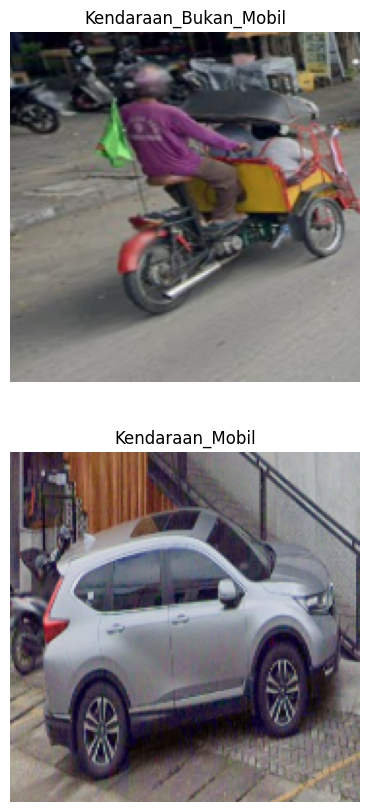

In [27]:
# lihat dataset training
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(2):
    ax = plt.subplot(2, 1, i + 1) # 3 baris, 3 kolom
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [28]:
# 32 per batch, 180x180 pixel, warna 3 (RGB)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [30]:
# normalisasi
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# nilai dari [0 sd 255] menjadi [0 sd 1]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [31]:
num_classes = len(train_ds)

model = tf.keras.models.Sequential([
 layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
 layers.Conv2D(16, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Conv2D(32, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Conv2D(64, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Flatten(),
 layers.Dense(128, activation='relu'),
 layers.Dense(1, activation='sigmoid')
])


In [32]:
# menggunakan binary karena dataset hanya terdiri dari 2 kelas (kalau lebih dari 2 kelas memakai tipe kategori)
model.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=['accuracy'])


In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [34]:
#training data
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
30/30 [==============================] - 4s 97ms/step - loss: 0.6359 - accuracy: 0.6253 - val_loss: 0.5042 - val_accuracy: 0.7414
Epoch 2/10
30/30 [==============================] - 1s 24ms/step - loss: 0.5113 - accuracy: 0.7337 - val_loss: 0.4616 - val_accuracy: 0.7389
Epoch 3/10
30/30 [==============================] - 1s 22ms/step - loss: 0.3805 - accuracy: 0.8179 - val_loss: 0.3842 - val_accuracy: 0.8300
Epoch 4/10
30/30 [==============================] - 1s 23ms/step - loss: 0.2776 - accuracy: 0.8789 - val_loss: 0.3766 - val_accuracy: 0.8498
Epoch 5/10
30/30 [==============================] - 1s 24ms/step - loss: 0.1955 - accuracy: 0.9158 - val_loss: 0.3611 - val_accuracy: 0.8621
Epoch 6/10
30/30 [==============================] - 1s 25ms/step - loss: 0.1169 - accuracy: 0.9589 - val_loss: 0.4705 - val_accuracy: 0.8103
Epoch 7/10
30/30 [==============================] - 1s 26ms/step - loss: 0.1241 - accuracy: 0.9589 - val_loss: 0.3860 - val_accuracy: 0.8695
Epoch 8/10
30

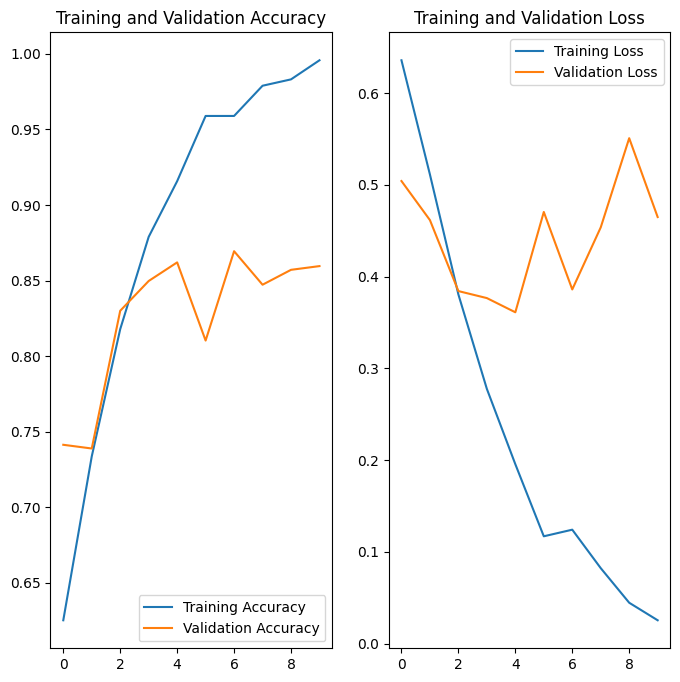

In [35]:
#menampilkan plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [36]:
# data augmentasi agar mengurangi overfit
data_augmentation = keras.Sequential(
 [
   layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
   layers.RandomRotation(0.1),
   layers.RandomZoom(0.1),
 ]
)


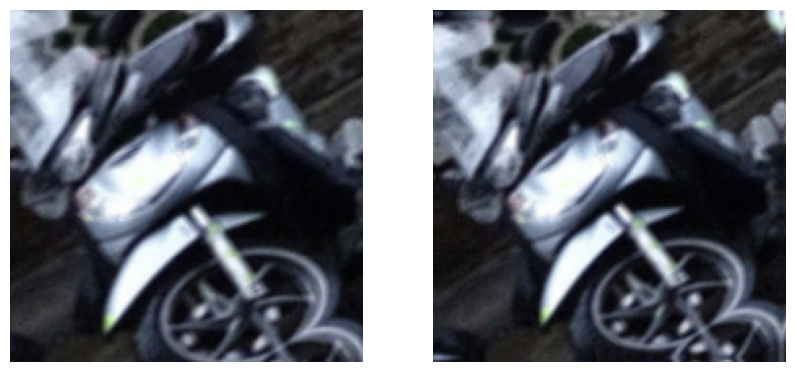

In [37]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
 for i in range(2):
   augmented_images = data_augmentation(images)
   ax = plt.subplot(1, 2, i + 1)
   plt.imshow(augmented_images[0].numpy().astype("uint8"))
   plt.axis("off")


In [38]:
model = Sequential([
 data_augmentation,
 layers.Rescaling(1./255),
 layers.Conv2D(64, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Conv2D(128, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Conv2D(256, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Conv2D(512, 3, padding='same', activation='relu'),
 layers.MaxPooling2D(),
 layers.Dropout(0.2),
 layers.Flatten(),
 #layers.Dense(128, activation='relu'),
 layers.Dense(1, activation='sigmoid')
])


In [39]:

model.compile(optimizer='adam',
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=['accuracy'])
epochs = 15
history = model.fit(
 train_ds,
 validation_data=val_ds,
 epochs=epochs
)

Epoch 1/15
30/30 [==============================] - 11s 188ms/step - loss: 0.6923 - accuracy: 0.5484 - val_loss: 0.5624 - val_accuracy: 0.6897
Epoch 2/15
30/30 [==============================] - 4s 127ms/step - loss: 0.5937 - accuracy: 0.6958 - val_loss: 0.5828 - val_accuracy: 0.7217
Epoch 3/15
30/30 [==============================] - 4s 125ms/step - loss: 0.5146 - accuracy: 0.7484 - val_loss: 0.6120 - val_accuracy: 0.7315
Epoch 4/15
30/30 [==============================] - 4s 128ms/step - loss: 0.4857 - accuracy: 0.7547 - val_loss: 0.4808 - val_accuracy: 0.7882
Epoch 5/15
30/30 [==============================] - 4s 123ms/step - loss: 0.4903 - accuracy: 0.7663 - val_loss: 0.4382 - val_accuracy: 0.7833
Epoch 6/15
30/30 [==============================] - 4s 124ms/step - loss: 0.4376 - accuracy: 0.8074 - val_loss: 0.4890 - val_accuracy: 0.7586
Epoch 7/15
30/30 [==============================] - 4s 126ms/step - loss: 0.4338 - accuracy: 0.7947 - val_loss: 0.3729 - val_accuracy: 0.8399
Epoch

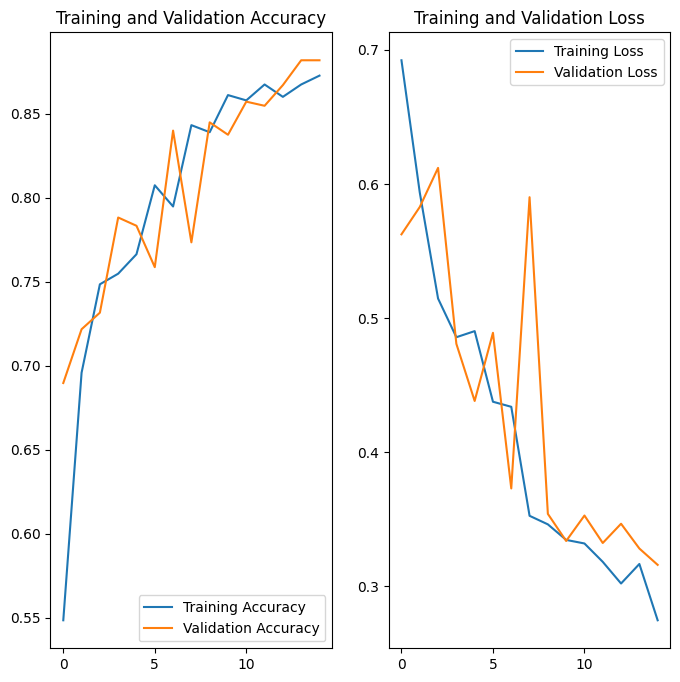

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
#menampilkan hasil

from google.colab import files                                                                                            #Mengimpor modul import file

uploaded = files.upload()

for fn in uploaded.keys():
    temp_name = fn
    img = tf.keras.utils.load_img(temp_name, target_size=(img_height, img_width))
    plt.imshow(img)

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, batch_size)
    score = tf.nn.sigmoid(predictions[0])

    class_names = ['Bukan Mobil', 'Mobil']

    print(
        "Gambar dibawah merupakan kategori {} dengan akurasi {:.2f}%."
        .format(class_names[int(round(score.numpy()[0] - 0.2))], 100 * score.numpy()[0])
    )